In [1]:
# Imports
import pickle
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../')

from src import ansatzs as anz
from src import mitigation as mit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import FakeMelbourneV2
import time
from qiskit.quantum_info import Statevector

In [2]:
with open(f"data/ansatzH2O.pkl", "rb") as f:
    ansatz_naive = pickle.load(f)

backend = FakeMelbourneV2()

In [3]:
# Transpile circuit with a pass manager for a backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
transpiled_ansatz_naive = pm.run(ansatz_naive)
t1 = time.time()
t_optimized=t1 - t0

# Show results
print(f"Transpilation time: {t_optimized} (s)")
print(f'Circuit info: {transpiled_ansatz_naive.count_ops()}')
print(f'Depth: {transpiled_ansatz_naive.depth()}')

Transpilation time: 120.99440550804138 (s)
Circuit info: OrderedDict([('cx', 14262), ('rz', 6782), ('sx', 4680), ('x', 267)])
Depth: 19258


In [ ]:
ansatz_opt, transpiled_ansatz_opt, num_cx_prev=anz.iterate_ansatz_opt(ansatz_naive, backend)

In [10]:
with open("data/ansatz_opt.pkl", "wb") as f:
    pickle.dump(ansatz_opt, f)

In [3]:
with open("data/ansatz_opt.pkl", "rb") as f:
    ansatz_opt = pickle.load(f)

In [5]:
print(f'Circuit info: {transpiled_ansatz_opt.count_ops()}')
print(f'Depth: {transpiled_ansatz_opt.depth()}')

Circuit info: OrderedDict([('cx', 13456), ('rz', 6858), ('sx', 4686), ('x', 561)])
Depth: 18986


## Comparison of ansatz

In [12]:
# Randomización de parámetros
num_params = ansatz_naive.num_parameters
x0 = np.random.uniform(0,2*np.pi,num_params)

# Ansatz sin optimizar
qc_1 = ansatz_naive.assign_parameters({list(ansatz_naive.parameters)[i]: x0[i] for i in range(len(x0))}) # Asignamos los parámetros al circuito
Sv_1 = Statevector(qc_1)
display(Sv_1.draw('latex'))

# Ansatz optimizado
qc_2 = ansatz_opt.assign_parameters({list(ansatz_opt.parameters)[i]: x0[i] for i in range(len(x0))}) # Asignamos los parámetros al circuito
Sv_2 = Statevector(qc_2)
display(Sv_2.draw('latex'))

# Fidelidad y distancia
print(abs(np.dot(Sv_1,Sv_2)))
print(abs(np.linalg.norm(Sv_1-Sv_2)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

0.9999999999987133
1.6057776596625765e-13


In [4]:
with open("data/H2O_hamiltonian.pkl", "rb") as f:
    hamiltonian = pickle.load(f)

In [5]:
cost_history_dict_naive=mit.VQE_minimization(ansatz_naive, hamiltonian, maxiter=1000, fixseed=True)
with open("data/cost_history_dict_naive.pkl", "wb") as f:
    pickle.dump(cost_history_dict_naive, f)

In [ ]:
cost_history_dict_opt=mit.VQE_minimization(ansatz_opt, hamiltonian, maxiter=1000, fixseed=True)
with open("data/cost_history_dict_opt.pkl", "wb") as f:
    pickle.dump(cost_history_dict_opt, f)

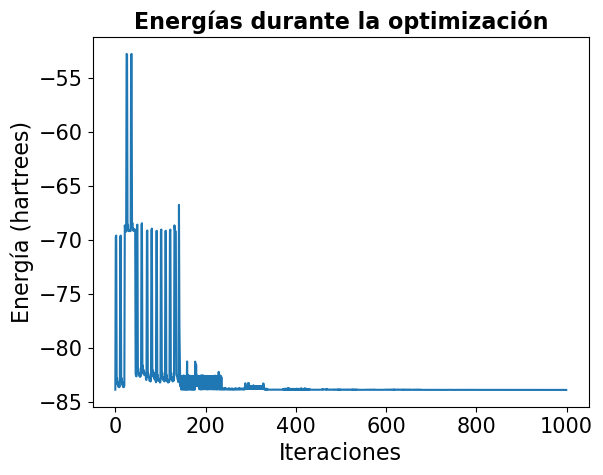

In [16]:
plt.figure()
plt.plot(range(cost_history_dict_opt["iters"]), cost_history_dict_opt["cost_history"])
plt.title("Energías durante la optimización", size=16, fontweight="bold")
plt.xlabel("Iteraciones", size=16)
plt.ylabel("Energía (hartrees)", size=16)
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.show()